In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from collections import Counter
import json

# Data Preprocessing

In order to analyze the underlying structure of the Reddit submissions, I preprocessed the submission information contained in 'submission_info.txt'. In particular, I paid close attention to the author and the subreddit as I am interested in whether there are any patterns between author and subreddit. In this exploratory data analysis, I chose the top 1000 authors and top 1000 subreddits as a starting point and formed a 1000x1000 matrix where the (i,j)-th term is the frequency of jth author submitted to ith subreddit.

In [2]:
info = pd.read_table('submission_info.txt')

author_counter = Counter(info['AUTHOR'])
sub_counter = Counter(info['SUBREDDIT'])

author1000 = author_counter.most_common(1003)[3:] # the first three authors are trivial 
sub1000 = sub_counter.most_common(1000)

In [3]:
# You may skip this step if author1000_count.json is ready

author1000_counter = {}

for i, author in enumerate(author1000):
    author1000_counter[author[0]] = Counter(info[info['AUTHOR'] == author[0]]['SUBREDDIT'])
    
with open('author1000_count.json', 'w') as fp:
    json.dump(author1000_counter, fp)

In [105]:
with open('author1000_count.json') as f:
    author1000_count = json.load(f)

In [107]:
freq = np.zeros((1000,1000))

for i, sub in enumerate(sub1000):
    for j, author in enumerate(author1000):
        freq[i,j] = author1000_counter[author[0]][sub[0]]

In [109]:
np.sum(freq == 0)

975253

The resultant matrix is very sparse. For the actual matrix with even larger dimensions, I may consider saving it as a sparse matrix using scipy.sparse.save_npz

# Dimension reduction using SVD

In [122]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500)
svd.fit(freq.T)

explained_var_lst = np.cumsum(svd.explained_variance_ratio_/svd.explained_variance_ratio_.sum())

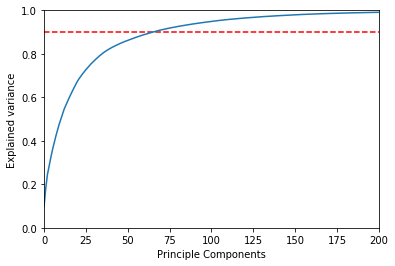

In [123]:
plt.plot(explained_var_lst)
plt.xlabel('Principle Components')
plt.ylabel('Explained variance')
plt.xlim([0,200])
plt.ylim([0,1])
plt.hlines(y=0.9,xmin=0,xmax=500,linestyle='dashed',color='r')
plt.show()

According to the plot, the top 65 principle components can explain 90% of the explained variance.

In [124]:
svd.components_.shape

(500, 1000)

In [125]:
Z = svd.fit_transform(X.T)

In [132]:
for i in range(0,10):
    #Z_sort = np.argsort(np.abs(Z[:,i]))
    Z_sort = np.argsort(Z[:,i])
    print('Component ' + str(i))
    for j in range(1,5):
        sub_index = Z_sort[-j]
        sub_title = sub1000[sub_index][0]
        sub_weight = Z[sub_index,i]
        print(str(sub_title) + ': ' + str(sub_weight))
    print(' ')

Component 0
Tay_5: 4864.767947953098
Pikabu: 1580.1168903073187
cosplaygirls: 2.7372578913124386
memes: 2.3458956465307357
 
Component 1
teenagersnew: 4713.000636514362
Kanye: 1.00021484051568
pcmasterrace: 0.01341641171378376
MemeEconomy: 0.00962120691817023
 
Component 2
politics: 3018.8043611087573
worldnews: 2766.2932376674635
technology: 670.423920562017
science: 562.9608618927721
 
Component 3
Conservative: 2601.0915058183373
The_Donald: 1125.8817060918639
worldpolitics: 881.1158452435213
POLITIC: 792.4712782866508
 
Component 4
worldnews: 2180.2538624702
Conservative: 870.3217657870622
The_Donald: 260.0636789716309
technology: 184.2436271345152
 
Component 5
POLITIC: 2610.956656972473
AnythingGoesNews: 1381.7232121923346
worldnews: 309.0740710767672
worldpolitics: 104.81943862457265
 
Component 6
Futurology: 1791.1751830791382
science: 1609.2657596060694
technology: 1436.1262237237293
space: 242.93382750725556
 
Component 7
nfl: 2255.1180474489356
SquaredCircle: 1718.75822506448

By printing the top 10 components, I can see each component indeed represents a bunch of related subreddit. For example, Component 7 clearly represents the sports subreddit, whereas Component 6 represents mostly science and technology. Interestingly, Component 3,4 and 8 all shared 'r/The_Donald' and they seem to be related to politics and conservative. 

This intial analysis not only reveals the latent structure of subreddit submissions, but also demonstrates the potential of using reduced dimension for any supervised learning tasks, otherwise the feature space for subreddit would be mostly sparse.